In [1]:
%autosave 0

Autosave disabled


In [2]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape, cal_score_smooth

In [3]:
stack_idx = '16'
models = '1-27'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = False
add_intercept = True

### Read CV predictions and test

In [4]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [5]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [6]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [7]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [8]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [9]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [10]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
27
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.000

In [11]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [12]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.368623,12.139520,6.452832e+05,13.377446,12.148343,6.477905e+05,13.381324,12.152221,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.964998,13.568430,3.164660e+06,14.967557,13.570989,3.127411e+06,14.955716,13.559149,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.099372,14.379417,9.832843e+06,16.101239,14.381284,9.745913e+06,16.092359,14.372404,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.360680,13.753334,1.274179e+07,16.360398,13.753051,1.259548e+07,16.348848,13.741502,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.950262,12.405236,1.114412e+06,13.923838,12.378812,1.131428e+06,13.938992,12.393966,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_24,pred_25,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.189986,1.456214e+07,16.493936,15.264829,1.358120e+07,16.424197,15.195091,1.405424e+07,16.458435,15.229328
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.140432,3.903389e+06,15.177356,13.132737,3.915563e+06,15.180470,13.135851,3.932854e+06,15.184876,13.140257
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.643765,1.064055e+07,16.180183,13.681162,1.076414e+07,16.191730,13.692710,1.040041e+07,16.157355,13.658335
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.778239,6.006309e+06,15.608321,14.796389,6.034948e+06,15.613078,14.801146,5.905111e+06,15.591329,14.779397
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.188114,1.091787e+06,13.903327,12.143065,1.096191e+06,13.907353,12.147091,1.048505e+06,13.862877,12.102615


### Check models scores

In [13]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-24 5866.873835
24 model-25 5908.874238
25 model-26 5918.873998
26 model-27 5892.873194


In [14]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [15]:
def objective(x, metric):
    cv_pred_final = cv.loc[:,cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    global best_score
    global best_coeffs
    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        print('find better score:')
        print('score: ', score)
        print('coeffs: ', x)
        print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    elif metric == 'smooth':
        return cal_score_smooth(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Optimize

In [16]:
best_score = {}
best_coeffs = {}

len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [ [1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)] ]

for metric in ['smooth']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(metric), tol=1e-4)

Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]

find better score:
score:  155.59830708423098
coeffs:  [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]

find better sco

find better score:
score:  5992.876436233761
coeffs:  [-0.08510745  0.0259262  -0.05537261  0.04835575  0.167932    0.10153241
  0.02107577  0.11967588  0.01954557 -0.05590846 -0.1096726   0.01092806
  0.04685988 -0.28079126 -0.00125463  0.04661311  0.21895874  0.20118381
 -0.07927237 -0.44193373 -0.03007657 -0.03469382  0.12104106  0.20720887
 -0.24500337  0.74394192  0.32197921 -0.06016781]

find better score:
score:  5992.876439160306
coeffs:  [-0.08554082  0.0262366  -0.0578475   0.048279    0.16492417  0.10400266
  0.02095693  0.11995836  0.02102007 -0.05809153 -0.10936784  0.01117663
  0.04600209 -0.29671096  0.01512835  0.04482628  0.21730201  0.20079533
 -0.11221583 -0.44330603 -0.03282041 -0.02553015  0.12158877  0.2058694
 -0.21770414  0.75332944  0.32141629 -0.06026349]

find better score:
score:  5993.876431841113
coeffs:  [-0.08660328  0.02640318 -0.05945172  0.04872125  0.16376643  0.10427733
  0.02087357  0.120219    0.02415413 -0.06456116 -0.10951484  0.01059804
  0.046

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


Optimizing with init x0: [-0.8726932389968284, 0.027424018804115158, 0.5933487103710847, 0.9842573586402549, -0.8510334414204981, 0.8062728368014872, -0.5535060656266103, 1.5705526341959961, -0.24954993283803173, -0.9638287876600231, 1.1718474056017583, 0.799456924236482, -1.2629623010625708, -2.9246998977885474, -1.5819221430209973, 0.8737192438698255, -0.04356709113443705, -0.7545847928994177, 1.2395461890622412, 0.17157450120707451, 0.4013084443303488, -1.0057769839563215, 0.02863244089554653, 0.8358006545543823, -0.10652865066984336, -0.9608613554522256, -0.2484450506986629, 0.9137244606829884]

Optimizing with init x0: [0.8005178898445154, 0.3376189509349258, -0.2862032307981575, -1.0608486431357518, -0.0020375552550312356, -1.8176344599087857, 0.4581808256035291, -0.20319659517921046, -1.6892328737217466, 1.720723248013979, -0.1026730126519083, -1.0324706161715551, -1.7930083016673892, 1.6713855101366297, -0.17537682901047763, 0.286902185399739, -0.305322670581941, 1.004406557712

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


Optimizing with init x0: [0.13786452616914552, 1.409131390908759, 0.44569303177274217, 0.4706241645131722, -0.5853733229902165, 0.46893581273208385, 0.15554781228417697, 0.007588754071306877, -1.5268027502159027, -1.0609069090490586, 0.8431798871148785, 1.1415192914059948, -1.5631269123633615, -0.6796731641159276, -0.8666134508700845, -0.26613761700142147, 0.2997668921308929, 0.7702688373650263, 1.202421399852793, 1.903955881859732, -2.2479903411753877, 2.712705154040208, 2.087540134330672, -0.9546620152657694, 2.7722395269956217, 0.8658980107641987, -0.6322765522992749, 0.6587332566454909]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in expm1
  import sys


In [17]:
display(best_score)
display(best_coeffs)

{'smooth': 5993.876431841113}

{'smooth': array([-0.08660328,  0.02640318, -0.05945172,  0.04872125,  0.16376643,
         0.10427733,  0.02087357,  0.120219  ,  0.02415413, -0.06456116,
        -0.10951484,  0.01059804,  0.04653014, -0.33844043,  0.04896744,
         0.04682046,  0.21944719,  0.20985684, -0.19790726, -0.45162354,
        -0.04511935, -0.01503415,  0.12330399,  0.20187907, -0.15388368,
         0.7843983 ,  0.32558471, -0.06002836])}

### Compute submission

In [21]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['smooth'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)

### Plots

In [22]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


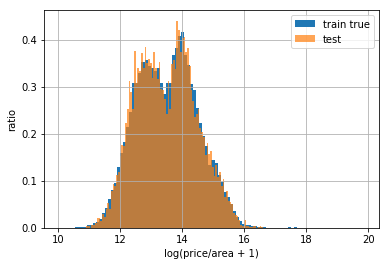

In [23]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

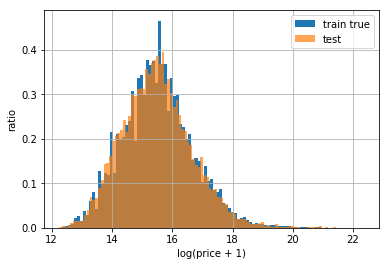

In [24]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

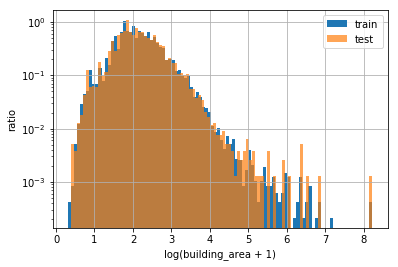

In [25]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [ ]:
print([1/17 if i in [3, 4, 5, 7, 8, 12, 13, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26] else 0 \
 for i in range(1,28)])